<a href="https://colab.research.google.com/github/ArthBachhuka123/ML-Projects/blob/main/WeatherPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [162]:
global_data = pd.read_csv("/content/drive/MyDrive/files/weather_data.csv")

In [163]:
global_data.sample(5)

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
2960,1996-09-01,12.294,0.053,17.974,0.116,6.711,0.17,16.444,0.056
1064,1838-09-01,11.106,0.889,NaN,NaN,NaN,NaN,NaN,NaN
837,1819-10-01,9.312,1.223,NaN,NaN,NaN,NaN,NaN,NaN
172,1764-05-01,11.175,4.550,NaN,NaN,NaN,NaN,NaN,NaN
778,1814-11-01,6.739,3.428,NaN,NaN,NaN,NaN,NaN,NaN


In [164]:
print(global_data.shape)
print(global_data.columns)

(3192, 9)
Index(['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty',
       'LandMaxTemperature', 'LandMaxTemperatureUncertainty',
       'LandMinTemperature', 'LandMinTemperatureUncertainty',
       'LandAndOceanAverageTemperature',
       'LandAndOceanAverageTemperatureUncertainty'],
      dtype='object')


In [165]:
Uncertainty_cols = []
for cols in global_data.columns:
  if "Uncertainty" in cols:
    Uncertainty_cols.append(cols)
def clean_data(global_data):
  global_data = global_data.drop(columns=Uncertainty_cols,axis=1)
  df = global_data.copy()
  df["dt"] = pd.to_datetime(df["dt"])
  df["Year"] = df["dt"].dt.year
  df["Month"] = df["dt"].dt.month
  df["Day"] = df["dt"].dt.day
  df.drop(columns=["dt"],inplace=True)
  df = df.set_index(["Year"])
  return df
Uncertainty_cols


['LandAverageTemperatureUncertainty',
 'LandMaxTemperatureUncertainty',
 'LandMinTemperatureUncertainty',
 'LandAndOceanAverageTemperatureUncertainty']

In [166]:
global_data = clean_data(global_data)

In [167]:
global_data.isnull().sum()

,0
LandAverageTemperature,12
LandMaxTemperature,1200
LandMinTemperature,1200
LandAndOceanAverageTemperature,1200
Month,0
Day,0


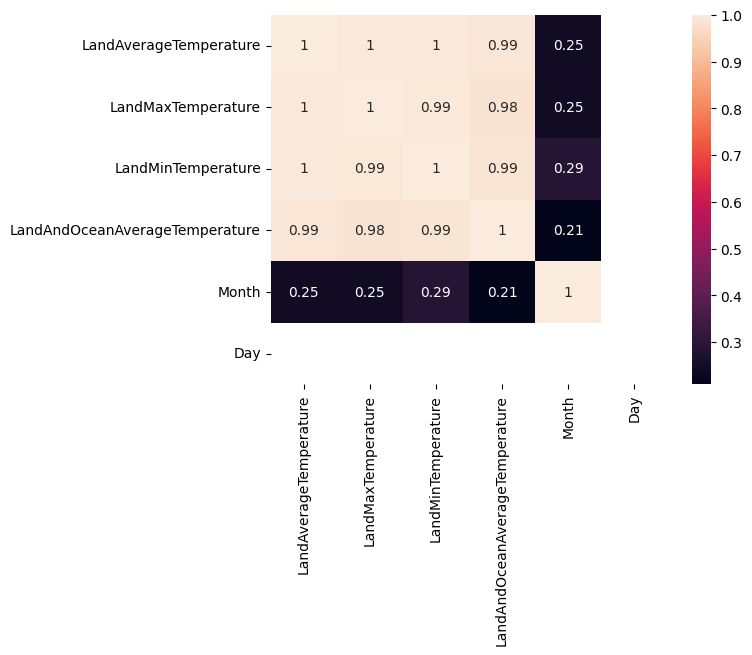

In [168]:
corrMatrix = global_data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [169]:
# global_data["LandAndOceanAverageTemperature"].dropna(inplace=True)
# global_data.isnull().sum()
global_data = global_data.dropna(subset=["LandAndOceanAverageTemperature"])
global_data["LandAndOceanAverageTemperature"]

,LandAndOceanAverageTemperature
Year,
1850,12.833
1850,13.588
1850,14.043
1850,14.667
1850,15.507
...,...
2015,17.589
2015,17.049
2015,16.290


In [170]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,r2_score
X_train,X_test,y_train,y_test = train_test_split(global_data.drop(columns=["LandAndOceanAverageTemperature"]),global_data["LandAndOceanAverageTemperature"],test_size=0.2,random_state=42)

# Creating Pipeline
pipe = Pipeline([
    ("imputing",SimpleImputer()),
    ("model",LinearRegression())
])

# Parameters for GridSearchCv
param_grid_pipe = [
    {
        'imputing': [SimpleImputer()],
        'imputing__strategy': ['mean', 'median']
    },
    {
        'imputing': [KNNImputer()],
        'imputing__n_neighbors': [3, 5, 7]
    },
    {
        'model': [LinearRegression()],
    },
    {
        'model': [SGDRegressor()],
        'model__alpha': [0.0001, 0.001, 0.01],
    },
    {
        'model': [DecisionTreeRegressor()],
        'model__max_depth': [None, 10, 20],
    },
    {
        'model': [RandomForestRegressor()],
        'model__n_estimators': [100, 200, 300],
    }
]

# Applying GridSearchCV
grid_pipe = GridSearchCV(pipe,param_grid_pipe,cv=5,verbose=2,n_jobs=-1,scoring="r2")
grid_pipe.fit(X_train,y_train)

print(grid_pipe.best_params_)
print(grid_pipe.best_score_)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
{'model': RandomForestRegressor(), 'model__n_estimators': 300}
0.9907863460309523


In [171]:
best_model = grid_pipe.best_estimator_

In [172]:
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

In [173]:
print(f"Test r2 score : {np.round(r2_score(y_test,y_pred),3)}")
print(f"Test mse : {np.round(mean_squared_error(y_test,y_pred),3)}")
print(f"Test rmse {np.round(np.sqrt(mean_squared_error(y_test,y_pred)),3)}")
print(f"Train r2 score : {np.round(r2_score(y_train,y_pred_train),3)}")
print(f"Train mse : {np.round(mean_squared_error(y_train,y_pred_train),3)}")
print(f"Train rmse {np.round(np.sqrt(mean_squared_error(y_train,y_pred_train)),3)}")

Test r2 score : 0.99
Test mse : 0.015
Test rmse 0.123
Train r2 score : 0.999
Train mse : 0.002
Train rmse 0.044
